# Text Processing

- A sub-field of Natural Language Processing (NLP)
- Natural Language Processing:
 - Teaching machines to understand and produce language (text, speech)
 - A combination of computer science and computational linguistics

Note: Speech is text processing + acoustic model

# Text Processing Tasks

- Word categorization and tagging: part of speech, type of entity
- Semantic Analysis: finding meanings of documents
- Topic Modeling: finding topics from documents
- Document similarity: comparing if two documents are semantically similar etc.


# Parsing, Stemming & Lemmatization

- Tokenization: splitting text into words
- Sentence boundary detection: splitting text into sentences
- Stemming: finding word stems
   - stating => state, reference => refer
- Stemming uses rule-based heuristics
  - ponies => poni
  - Quicker, but less precision
- Lemmatization: finding the base form of words
   - was => be
- Lemmatization uses vocabulary and morphological analysis
  - ponies => pony
  - For English, not much improvement over stemming because context of word use is more important

## Porter Stemmer

- a process for removing the commoner morphological and inflexional endings from words in English. Its main use is as part of a term normalisation process that is usually done when setting up Information Retrieval(IR) systems.

# Tokenization

- Segmenting text into words, punctuation, etc.
- Rule-based

# Word Vectors

- Represent word meanings in an efficient way

- Express word meaning based on context
 - Context: window of words around this word

# Toolkits

- NLTK: NLP toolkit


- spaCy: another NLP toolkit

Simpler to use than NLTK (but usually fewer knobs)

In [4]:
from gensim.models import Word2Vec, KeyedVectors
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy import spatial
from sklearn import decomposition
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

from pattern import es
import textract

In [5]:
df = pd.read_csv(r'C:\Xiaoxia\Study\AI4Change-Hachathon\dataset\db_exported_consolidate.csv')
df.generic_job_title.unique()

array(['Business Systems Analyst Jobs', 'IT Project Manager Jobs',
       'PHP Developer Jobs', 'IT Sales Jobs',
       'Project Office Support Jobs', 'Database Administrator Jobs',
       'IT Specialist Jobs', 'Service Delivery Jobs',
       'Database Developer Jobs', 'IT Support Analyst Jobs',
       'Service Desk Jobs', 'Desktop Support Engineer Jobs',
       'Data Analyst Jobs', 'IT Support Engineer Jobs',
       'Support Analyst Jobs', 'Development Engineer Jobs',
       'IT System Manager Jobs', 'Systems Admin Jobs', 'Digital Jobs',
       'Junior Designer Jobs', 'Systems Testing Jobs',
       'Enterprise Architect Jobs', 'Middleware Jobs',
       'Technical Architect Jobs', 'Erp Jobs',
       'Network Administration Jobs', 'Technical Consultant Jobs',
       'Functional Consultant Jobs', 'Network Administrator Jobs',
       'Technical Manager Jobs', 'Infrastructure Project Manager Jobs',
       'Network Analyst Jobs', 'Technical Support Engineer Jobs',
       'IT Jobs', 'Network

In [6]:
df.generic_job_title.unique().size

78

In [7]:
df.head()

,_id,generic_job_title,industry,job_details,specific_job_title
0,5b8961a9e18e1f3d54737e1c,Business Systems Analyst Jobs,IT,The position will be responsible for end-to-en...,"APAC IT Project Manager-Business Analyst, Cust..."
1,5b8961b8e18e1f3d54737e2c,Business Systems Analyst Jobs,IT,Report into the Global Markets/Global Business...,Business Analyst (FO)
2,5b8961b9e18e1f3d54737e2d,Business Systems Analyst Jobs,IT,Keen in growing your career as an Assistant Ma...,Assistant Manager IT Business Analyst
3,5b8961eee18e1f3d54737e59,Business Systems Analyst Jobs,IT,An exciting opportunity as a Technical Busines...,Business Analyst (Banking)
4,5b8961ffe18e1f3d54737e68,Business Systems Analyst Jobs,IT,Functional area: Grp GM - Business Management ...,"VP/AVP, Business Analyst (1 yr contract), Busi..."


In [8]:
df.isnull().values.any()

True

In [9]:
# there are NA values, drop them and then check again
df.dropna(inplace=True)
df.isnull().values.any()

False

In [10]:
df.groupby(['generic_job_title']).size()

generic_job_title
Administrative                       40
Business Advisor Jobs               483
Business Analyst Jobs               599
Business Strategy                    98
Business Systems Analyst Jobs       223
Change Management Jobs              711
Consultant Jobs                     509
Consulting Jobs                     586
Data Analyst Jobs                   253
Data Center & Network                 2
Database Administrator Jobs          89
Database Developer Jobs             155
Desktop Support Engineer Jobs        44
Developer Relations                   5
Development Engineer Jobs           448
Digital Jobs                        561
Enterprise Architect Jobs           196
Erp Jobs                            509
Finance                             115
Functional Consultant Jobs          299
Hardware Engineering                 22
IT & Data Management                  5
IT Auditor Jobs                     120
IT Director Jobs                    556
IT Jobs               

In [11]:
df.loc[df.generic_job_title == 'Data Center & Network', 'generic_job_title'] = 'IT & Data Management'
df.loc[df.generic_job_title == 'Network Engineering', 'generic_job_title'] = 'IT & Data Management'
df.groupby(['generic_job_title']).size()

generic_job_title
Administrative                       40
Business Advisor Jobs               483
Business Analyst Jobs               599
Business Strategy                    98
Business Systems Analyst Jobs       223
Change Management Jobs              711
Consultant Jobs                     509
Consulting Jobs                     586
Data Analyst Jobs                   253
Database Administrator Jobs          89
Database Developer Jobs             155
Desktop Support Engineer Jobs        44
Developer Relations                   5
Development Engineer Jobs           448
Digital Jobs                        561
Enterprise Architect Jobs           196
Erp Jobs                            509
Finance                             115
Functional Consultant Jobs          299
Hardware Engineering                 22
IT & Data Management                 13
IT Auditor Jobs                     120
IT Director Jobs                    556
IT Jobs                             425
IT Manager Jobs       

In [12]:
df.generic_job_title.unique().size

76

In [13]:
# Example text we want to convert
df.job_details[0]

"The position will be responsible for end-to-end implementation of APAC Customer & Commercial IT solutions, from definition, initiation, planning, implementation to operation-state (including documentation, problem & resolution management) across APAC. This person will lead the project management of transforming the business through digitization in the agreed scope, timeline & investment. This role shall provide subject-matter-expert in business digital transformation, systems & processes relating to Customer & Commercial functional areas.\r\n\r\nThe position will be a member of the APAC IT Customer & Commercial Systems team & reports to APAC IT COE Leader, Customer & Commercial Systems.\r\nFunction Specific Activities:\r\nKey Results:\r\nEstablishment of best practices in business transformation through digitalization\r\nSimplified/Streamlined business processes & practices with documentation\r\nCustomer & Commercial solutions implementation that meet established criteria for business

In [15]:

def preprocess_training_data1(text):       
    text = text.lower()
    wordcount = 0
    vector = []
    for sentence in es.parsetree(text, tokenize=True, lemmata=True, tags=True):
        temp = []
        for chunk in sentence.chunks:
            for word in chunk.words:
                if word.tag == 'NN' or word.tag == 'VB':
                    temp.append(word.lemma)
        vector.append(temp)
        wordcount += len(temp)    
    return vector,wordcount

In [16]:
print('Converting %d job_details to training set...' % len(df.job_details))

training_set = []
training_set_size = 0

for Res in df.job_details:
    wordlist, count = preprocess_training_data1(Res)

    training_set_size += count
    training_set += wordlist
    
print('Training set size: %d stem words, %d sentences' \
      % (training_set_size, len(training_set)))

Converting 20093 job_details to training set...
Training set size: 5500129 stem words, 277756 sentences


In [18]:
from gensim.models import word2vec

# Set values for various parameters
sg = 1                # Algorithm: 1: skip-gram, 0: CBOW
num_features = 200    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        
num_workers = 2       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Initialize and train the model.
# This may take a while if your training set is large (e.g. 500,000 words)
print('Training Word2Vec model...')
%time model = word2vec.Word2Vec(training_set, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
#dir of model is C:\Users\Sandy\NLP

model_name = "JobDesc_{}features_{}minwords_{}context_{}downsampling_c2.w2v" \
    .format(num_features, min_word_count, context, str(downsampling))
model.save(model_name)

print('Saved model as %s' % model_name)

Training Word2Vec model...


2018-09-24 11:27:37,323 : INFO : collecting all words and their counts
2018-09-24 11:27:37,324 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-09-24 11:27:37,362 : INFO : PROGRESS: at sentence #10000, processed 204040 words, keeping 10295 word types
2018-09-24 11:27:37,409 : INFO : PROGRESS: at sentence #20000, processed 393364 words, keeping 14881 word types
2018-09-24 11:27:37,452 : INFO : PROGRESS: at sentence #30000, processed 580461 words, keeping 18360 word types
2018-09-24 11:27:37,510 : INFO : PROGRESS: at sentence #40000, processed 783966 words, keeping 21221 word types
2018-09-24 11:27:37,560 : INFO : PROGRESS: at sentence #50000, processed 968236 words, keeping 23798 word types
2018-09-24 11:27:37,613 : INFO : PROGRESS: at sentence #60000, processed 1154263 words, keeping 26046 word types
2018-09-24 11:27:37,660 : INFO : PROGRESS: at sentence #70000, processed 1351375 words, keeping 28123 word types
2018-09-24 11:27:37,705 : INFO : PROGRESS: a

2018-09-24 11:28:03,658 : INFO : EPOCH - 5 : training on 5500129 raw words (4389967 effective words) took 4.8s, 906335 effective words/s
2018-09-24 11:28:03,659 : INFO : training on a 27500645 raw words (21949285 effective words) took 24.7s, 888846 effective words/s


Wall time: 26.3 s


2018-09-24 11:28:03,661 : INFO : precomputing L2-norms of word weight vectors
2018-09-24 11:28:03,748 : INFO : saving Word2Vec object under JobDesc_200features_10minwords_10context_0.001downsampling_c2.w2v, separately None
2018-09-24 11:28:03,749 : INFO : not storing attribute vectors_norm
2018-09-24 11:28:03,751 : INFO : not storing attribute cum_table
2018-09-24 11:28:03,989 : INFO : saved JobDesc_200features_10minwords_10context_0.001downsampling_c2.w2v


Saved model as JobDesc_200features_10minwords_10context_0.001downsampling_c2.w2v


In [19]:
model = word2vec.Word2Vec.load(model_name)

2018-09-24 11:30:18,427 : INFO : loading Word2Vec object from JobDesc_200features_10minwords_10context_0.001downsampling_c2.w2v
2018-09-24 11:30:18,584 : INFO : loading wv recursively from JobDesc_200features_10minwords_10context_0.001downsampling_c2.w2v.wv.* with mmap=None
2018-09-24 11:30:18,585 : INFO : setting ignored attribute vectors_norm to None
2018-09-24 11:30:18,586 : INFO : loading vocabulary recursively from JobDesc_200features_10minwords_10context_0.001downsampling_c2.w2v.vocabulary.* with mmap=None
2018-09-24 11:30:18,587 : INFO : loading trainables recursively from JobDesc_200features_10minwords_10context_0.001downsampling_c2.w2v.trainables.* with mmap=None
2018-09-24 11:30:18,588 : INFO : setting ignored attribute cum_table to None
2018-09-24 11:30:18,589 : INFO : loaded JobDesc_200features_10minwords_10context_0.001downsampling_c2.w2v


In [20]:
# number of words in the vocab
len(model.wv.vocab) # model.wv.vocab is dictionary

12662

In [15]:
for key, value in model.wv.vocab.items():
    print (key, value)

posit Vocab(count:9112, index:88, sample_int:4294967296)
respons Vocab(count:27446, index:11, sample_int:2456472739)
end Vocab(count:6731, index:129, sample_int:4294967296)
implement Vocab(count:15165, index:40, sample_int:3634545426)
apac Vocab(count:3550, index:290, sample_int:4294967296)
custom Vocab(count:26615, index:13, sample_int:2505698050)
commerci Vocab(count:3397, index:303, sample_int:4294967296)
solut Vocab(count:21118, index:22, sample_int:2913783287)
definit Vocab(count:668, index:1030, sample_int:4294967296)
initi Vocab(count:6597, index:136, sample_int:4294967296)
plan Vocab(count:16182, index:37, sample_int:3478752033)
oper Vocab(count:19750, index:28, sample_int:3045503582)
state Vocab(count:1396, index:635, sample_int:4294967296)
includ Vocab(count:18163, index:33, sample_int:3219782423)
document Vocab(count:8514, index:98, sample_int:4294967296)
problem Vocab(count:8541, index:97, sample_int:4294967296)
resolut Vocab(count:2184, index:442, sample_int:4294967296)
ma

opportun Vocab(count:12981, index:52, sample_int:4040725055)
smart Vocab(count:794, index:920, sample_int:4294967296)
make Vocab(count:6685, index:130, sample_int:4294967296)
bold Vocab(count:115, index:2602, sample_int:4294967296)
recommend Vocab(count:3476, index:298, sample_int:4294967296)
extern Vocab(count:5240, index:185, sample_int:4294967296)
upstream Vocab(count:114, index:2613, sample_int:4294967296)
downstream Vocab(count:111, index:2643, sample_int:4294967296)
implic Vocab(count:278, index:1684, sample_int:4294967296)
trend Vocab(count:2802, index:365, sample_int:4294967296)
driven Vocab(count:3167, index:327, sample_int:4294967296)
high Vocab(count:8236, index:106, sample_int:4294967296)
standard Vocab(count:6614, index:133, sample_int:4294967296)
outperform Vocab(count:43, index:4145, sample_int:4294967296)
peer Vocab(count:779, index:930, sample_int:4294967296)
fast Vocab(count:4026, index:250, sample_int:4294967296)
remov Vocab(count:161, index:2198, sample_int:42949672

suitabl Vocab(count:796, index:917, sample_int:4294967296)
summari Vocab(count:1154, index:725, sample_int:4294967296)
output Vocab(count:370, index:1466, sample_int:4294967296)
weekli Vocab(count:730, index:965, sample_int:4294967296)
level Vocab(count:11617, index:59, sample_int:4294967296)
rpa Vocab(count:225, index:1886, sample_int:4294967296)
accur Vocab(count:2029, index:467, sample_int:4294967296)
map Vocab(count:925, index:838, sample_int:4294967296)
uat Vocab(count:735, index:961, sample_int:4294967296)
closur Vocab(count:558, index:1159, sample_int:4294967296)
compli Vocab(count:707, index:989, sample_int:4294967296)
regulatori Vocab(count:2752, index:373, sample_int:4294967296)
intern Vocab(count:12439, index:55, sample_int:4160877009)
polici Vocab(count:5641, index:169, sample_int:4294967296)
commit Vocab(count:3322, index:314, sample_int:4294967296)
10 Vocab(count:3110, index:333, sample_int:4294967296)
acumen Vocab(count:910, index:853, sample_int:4294967296)
via Vocab(co

clearli Vocab(count:710, index:985, sample_int:4294967296)
limit Vocab(count:2027, index:469, sample_int:4294967296)
control Vocab(count:6563, index:137, sample_int:4294967296)
collat Vocab(count:277, index:1688, sample_int:4294967296)
proof Vocab(count:451, index:1299, sample_int:4294967296)
saniti Vocab(count:24, index:5341, sample_int:4294967296)
specialist Vocab(count:1870, index:503, sample_int:4294967296)
success Vocab(count:10120, index:76, sample_int:4294967296)
sap Vocab(count:3315, index:316, sample_int:4294967296)
sd Vocab(count:211, index:1930, sample_int:4294967296)
senior Vocab(count:5986, index:157, sample_int:4294967296)
modul Vocab(count:956, index:814, sample_int:4294967296)
complet Vocab(count:3577, index:286, sample_int:4294967296)
pm Vocab(count:561, index:1153, sample_int:4294967296)
cm Vocab(count:198, index:1985, sample_int:4294967296)
roll Vocab(count:646, index:1050, sample_int:4294967296)
configur Vocab(count:2973, index:345, sample_int:4294967296)
scenario V

intend Vocab(count:170, index:2131, sample_int:4294967296)
exhaust Vocab(count:93, index:2893, sample_int:4294967296)
employe Vocab(count:5459, index:176, sample_int:4294967296)
held Vocab(count:125, index:2507, sample_int:4294967296)
overview Vocab(count:846, index:887, sample_int:4294967296)
celestica Vocab(count:34, index:4592, sample_int:4294967296)
nyse Vocab(count:133, index:2437, sample_int:4294967296)
tsx Vocab(count:16, index:6475, sample_int:4294967296)
cl Vocab(count:34, index:4593, sample_int:4294967296)
lifecycl Vocab(count:1162, index:720, sample_int:4294967296)
trust Vocab(count:1641, index:557, sample_int:4294967296)
manufactur Vocab(count:3287, index:319, sample_int:4294967296)
sophist Vocab(count:175, index:2100, sample_int:4294967296)
medic Vocab(count:1473, index:622, sample_int:4294967296)
aviat Vocab(count:253, index:1766, sample_int:4294967296)
bar Vocab(count:98, index:2811, sample_int:4294967296)
reliabl Vocab(count:1113, index:743, sample_int:4294967296)
aeros

previou Vocab(count:868, index:878, sample_int:4294967296)
assimil Vocab(count:66, index:3425, sample_int:4294967296)
consensu Vocab(count:159, index:2213, sample_int:4294967296)
persuas Vocab(count:245, index:1805, sample_int:4294967296)
techniqu Vocab(count:1639, index:560, sample_int:4294967296)
xpand Vocab(count:75, index:3219, sample_int:4294967296)
link Vocab(count:714, index:982, sample_int:4294967296)
clarisa Vocab(count:24, index:5342, sample_int:4294967296)
ele Vocab(count:24, index:5343, sample_int:4294967296)
sg Vocab(count:2241, index:433, sample_int:4294967296)
cei Vocab(count:273, index:1705, sample_int:4294967296)
r1107413 Vocab(count:24, index:5344, sample_int:4294967296)
licenc Vocab(count:905, index:858, sample_int:4294967296)
07c3147 Vocab(count:45, index:4054, sample_int:4294967296)
liquid Vocab(count:287, index:1656, sample_int:4294967296)
specifi Vocab(count:350, index:1507, sample_int:4294967296)
datamart Vocab(count:17, index:6305, sample_int:4294967296)
regres

coc Vocab(count:14, index:6886, sample_int:4294967296)
finish Vocab(count:260, index:1744, sample_int:4294967296)
novarti Vocab(count:37, index:4416, sample_int:4294967296)
 Vocab(count:130, index:2465, sample_int:4294967296)
ml Vocab(count:145, index:2330, sample_int:4294967296)
tf Vocab(count:69, index:3361, sample_int:4294967296)
name Vocab(count:1360, index:646, sample_int:4294967296)
alert Vocab(count:433, index:1328, sample_int:4294967296)
str Vocab(count:34, index:4595, sample_int:4294967296)
exit Vocab(count:121, index:2548, sample_int:4294967296)
advisori Vocab(count:1061, index:766, sample_int:4294967296)
observ Vocab(count:226, index:1883, sample_int:4294967296)
highlight Vocab(count:380, index:1449, sample_int:4294967296)
refresh Vocab(count:187, index:2037, sample_int:4294967296)
ai Vocab(count:444, index:1312, sample_int:4294967296)
premier Vocab(count:266, index:1726, sample_int:4294967296)
offshor Vocab(count:289, index:1651, sample_int:4294967296)
lifestyl Vocab(count:

exploit Vocab(count:167, index:2153, sample_int:4294967296)
malwar Vocab(count:177, index:2092, sample_int:4294967296)
siem Vocab(count:183, index:2059, sample_int:4294967296)
charact Vocab(count:97, index:2828, sample_int:4294967296)
showcas Vocab(count:113, index:2623, sample_int:4294967296)
gcih Vocab(count:30, index:4813, sample_int:4294967296)
ccnp Vocab(count:276, index:1694, sample_int:4294967296)
msce Vocab(count:14, index:6890, sample_int:4294967296)
gcia Vocab(count:14, index:6891, sample_int:4294967296)
ceh Vocab(count:55, index:3720, sample_int:4294967296)
oscp Vocab(count:35, index:4534, sample_int:4294967296)
gcfa Vocab(count:14, index:6892, sample_int:4294967296)
cissp Vocab(count:298, index:1624, sample_int:4294967296)
coupl Vocab(count:398, index:1401, sample_int:4294967296)
appoint Vocab(count:566, index:1145, sample_int:4294967296)
colour Vocab(count:163, index:2183, sample_int:4294967296)
groom Vocab(count:181, index:2069, sample_int:4294967296)
draft Vocab(count:49

telephon Vocab(count:409, index:1378, sample_int:4294967296)
higher Vocab(count:831, index:895, sample_int:4294967296)
thai Vocab(count:168, index:2146, sample_int:4294967296)
reli Vocab(count:220, index:1905, sample_int:4294967296)
rigor Vocab(count:214, index:1927, sample_int:4294967296)
york Vocab(count:138, index:2392, sample_int:4294967296)
fresh Vocab(count:217, index:1917, sample_int:4294967296)
visualis Vocab(count:171, index:2126, sample_int:4294967296)
exploratori Vocab(count:43, index:4154, sample_int:4294967296)
dataset Vocab(count:166, index:2162, sample_int:4294967296)
phd Vocab(count:155, index:2231, sample_int:4294967296)
graphic Vocab(count:481, index:1261, sample_int:4294967296)
d3 Vocab(count:38, index:4361, sample_int:4294967296)
microstrategi Vocab(count:86, index:3005, sample_int:4294967296)
polym Vocab(count:29, index:4895, sample_int:4294967296)
jurong Vocab(count:146, index:2314, sample_int:4294967296)
automot Vocab(count:227, index:1880, sample_int:4294967296)

difficult Vocab(count:174, index:2108, sample_int:4294967296)
nice Vocab(count:210, index:1936, sample_int:4294967296)
postgresql Vocab(count:152, index:2260, sample_int:4294967296)
unusu Vocab(count:41, index:4230, sample_int:4294967296)
citigroup Vocab(count:41, index:4231, sample_int:4294967296)
trace Vocab(count:62, index:3531, sample_int:4294967296)
bahasa Vocab(count:140, index:2371, sample_int:4294967296)
jll Vocab(count:418, index:1353, sample_int:4294967296)
occupi Vocab(count:65, index:3455, sample_int:4294967296)
300 Vocab(count:206, index:1953, sample_int:4294967296)
landmark Vocab(count:62, index:3532, sample_int:4294967296)
entrepreneuri Vocab(count:665, index:1033, sample_int:4294967296)
globe Vocab(count:569, index:1140, sample_int:4294967296)
wellb Vocab(count:98, index:2814, sample_int:4294967296)
strength Vocab(count:476, index:1269, sample_int:4294967296)
wirecard Vocab(count:17, index:6318, sample_int:4294967296)
psp Vocab(count:19, index:6011, sample_int:429496729

eight Vocab(count:72, index:3287, sample_int:4294967296)
merg Vocab(count:34, index:4600, sample_int:4294967296)
sharepoint Vocab(count:428, index:1339, sample_int:4294967296)
brainstorm Vocab(count:131, index:2460, sample_int:4294967296)
storyboard Vocab(count:59, index:3605, sample_int:4294967296)
revert Vocab(count:12, index:7395, sample_int:4294967296)
sal Vocab(count:14, index:6899, sample_int:4294967296)
neha Vocab(count:25, index:5260, sample_int:4294967296)
singh Vocab(count:14, index:6900, sample_int:4294967296)
sarban Vocab(count:28, index:4987, sample_int:4294967296)
oxley Vocab(count:32, index:4703, sample_int:4294967296)
interrog Vocab(count:21, index:5735, sample_int:4294967296)
wish Vocab(count:373, index:1463, sample_int:4294967296)
eileen Vocab(count:10, index:8020, sample_int:4294967296)
wee Vocab(count:15, index:6689, sample_int:4294967296)
diagnos Vocab(count:280, index:1677, sample_int:4294967296)
prince2 Vocab(count:74, index:3239, sample_int:4294967296)
cio Vocab

cabl Vocab(count:277, index:1693, sample_int:4294967296)
complain Vocab(count:13, index:7143, sample_int:4294967296)
baccalaur Vocab(count:24, index:5366, sample_int:4294967296)
thousand Vocab(count:151, index:2272, sample_int:4294967296)
presal Vocab(count:338, index:1539, sample_int:4294967296)
kit Vocab(count:79, index:3142, sample_int:4294967296)
stat Vocab(count:26, index:5171, sample_int:4294967296)
flexi Vocab(count:41, index:4237, sample_int:4294967296)
eva Vocab(count:19, index:6023, sample_int:4294967296)
140 Vocab(count:37, index:4432, sample_int:4294967296)
split Vocab(count:33, index:4651, sample_int:4294967296)
kind Vocab(count:272, index:1711, sample_int:4294967296)
earlier Vocab(count:21, index:5740, sample_int:4294967296)
pmbok Vocab(count:15, index:6692, sample_int:4294967296)
fr Vocab(count:22, index:5600, sample_int:4294967296)
sizmek Vocab(count:10, index:8035, sample_int:4294967296)
timet Vocab(count:55, index:3726, sample_int:4294967296)
xhtml Vocab(count:22, ind

exemplari Vocab(count:51, index:3848, sample_int:4294967296)
ace Vocab(count:43, index:4164, sample_int:4294967296)
30am Vocab(count:181, index:2071, sample_int:4294967296)
aaron Vocab(count:14, index:6922, sample_int:4294967296)
chee Vocab(count:14, index:6923, sample_int:4294967296)
acerecruit Vocab(count:13, index:7157, sample_int:4294967296)
tee Vocab(count:28, index:4997, sample_int:4294967296)
hee Vocab(count:10, index:8050, sample_int:4294967296)
lon Vocab(count:10, index:8051, sample_int:4294967296)
instantli Vocab(count:17, index:6341, sample_int:4294967296)
prescript Vocab(count:54, index:3754, sample_int:4294967296)
afford Vocab(count:66, index:3434, sample_int:4294967296)
score Vocab(count:109, index:2684, sample_int:4294967296)
increment Vocab(count:169, index:2144, sample_int:4294967296)
fan Vocab(count:67, index:3414, sample_int:4294967296)
whatev Vocab(count:143, index:2349, sample_int:4294967296)
reproduc Vocab(count:46, index:4028, sample_int:4294967296)
curat Vocab(c

tremend Vocab(count:40, index:4283, sample_int:4294967296)
amd Vocab(count:18, index:6192, sample_int:4294967296)
font Vocab(count:203, index:1972, sample_int:4294967296)
defer Vocab(count:17, index:6353, sample_int:4294967296)
ingenico Vocab(count:10, index:8080, sample_int:4294967296)
epay Vocab(count:13, index:7172, sample_int:4294967296)
170 Vocab(count:25, index:5276, sample_int:4294967296)
approx Vocab(count:28, index:5008, sample_int:4294967296)
ignit Vocab(count:30, index:4837, sample_int:4294967296)
daniel Vocab(count:22, index:5616, sample_int:4294967296)
ampl Vocab(count:22, index:5617, sample_int:4294967296)
aesthet Vocab(count:167, index:2158, sample_int:4294967296)
perm Vocab(count:77, index:3191, sample_int:4294967296)
7k Vocab(count:12, index:7432, sample_int:4294967296)
steve Vocab(count:11, index:7760, sample_int:4294967296)
ling Vocab(count:34, index:4617, sample_int:4294967296)
thick Vocab(count:10, index:8081, sample_int:4294967296)
fortifi Vocab(count:13, index:71

kio Vocab(count:66, index:3438, sample_int:4294967296)
voicemail Vocab(count:21, index:5768, sample_int:4294967296)
brighter Vocab(count:12, index:7451, sample_int:4294967296)
hsbc Vocab(count:74, index:3247, sample_int:4294967296)
touchpoint Vocab(count:45, index:4081, sample_int:4294967296)
optimist Vocab(count:36, index:4499, sample_int:4294967296)
band Vocab(count:46, index:4036, sample_int:4294967296)
conferenc Vocab(count:124, index:2517, sample_int:4294967296)
haulio Vocab(count:10, index:8106, sample_int:4294967296)
stellar Vocab(count:36, index:4500, sample_int:4294967296)
telemarket Vocab(count:44, index:4125, sample_int:4294967296)
honest Vocab(count:51, index:3854, sample_int:4294967296)
sociabl  Vocab(count:52, index:3814, sample_int:4294967296)
prepay Vocab(count:16, index:6547, sample_int:4294967296)
seat Vocab(count:61, index:3571, sample_int:4294967296)
2002 Vocab(count:10, index:8117, sample_int:4294967296)
calmli Vocab(count:20, index:5911, sample_int:4294967296)
280

bcm Vocab(count:82, index:3097, sample_int:4294967296)
pedagog Vocab(count:19, index:6071, sample_int:4294967296)
hdf Vocab(count:61, index:3575, sample_int:4294967296)
flume Vocab(count:42, index:4214, sample_int:4294967296)
camel Vocab(count:27, index:5122, sample_int:4294967296)
dbunit Vocab(count:28, index:5031, sample_int:4294967296)
cacib Vocab(count:11, index:7826, sample_int:4294967296)
exot Vocab(count:25, index:5304, sample_int:4294967296)
pv Vocab(count:28, index:5032, sample_int:4294967296)
copyright Vocab(count:23, index:5518, sample_int:4294967296)
grc Vocab(count:79, index:3149, sample_int:4294967296)
teamciti Vocab(count:10, index:8158, sample_int:4294967296)
lta Vocab(count:92, index:2919, sample_int:4294967296)
psd Vocab(count:19, index:6072, sample_int:4294967296)
lodg Vocab(count:20, index:5935, sample_int:4294967296)
asc Vocab(count:16, index:6576, sample_int:4294967296)
6429 Vocab(count:16, index:6577, sample_int:4294967296)
chandler Vocab(count:20, index:5936, sa

willingli Vocab(count:14, index:7003, sample_int:4294967296)
flux Vocab(count:13, index:7262, sample_int:4294967296)
kofax Vocab(count:45, index:4090, sample_int:4294967296)
gpen Vocab(count:11, index:7851, sample_int:4294967296)
isr Vocab(count:10, index:8205, sample_int:4294967296)
inher Vocab(count:47, index:4002, sample_int:4294967296)
prc Vocab(count:11, index:7852, sample_int:4294967296)
outlier Vocab(count:21, index:5804, sample_int:4294967296)
collyer Vocab(count:13, index:7263, sample_int:4294967296)
biddabl Vocab(count:48, index:3960, sample_int:4294967296)
beta Vocab(count:35, index:4582, sample_int:4294967296)
1800 Vocab(count:32, index:4738, sample_int:4294967296)
insead Vocab(count:39, index:4349, sample_int:4294967296)
tushar Vocab(count:48, index:3961, sample_int:4294967296)
dadhwal Vocab(count:48, index:3962, sample_int:4294967296)
5938 Vocab(count:48, index:3963, sample_int:4294967296)
aesop Vocab(count:17, index:6409, sample_int:4294967296)
warmth Vocab(count:13, ind

1500 Vocab(count:13, index:7300, sample_int:4294967296)
bluecoat Vocab(count:37, index:4458, sample_int:4294967296)
cabin Vocab(count:12, index:7595, sample_int:4294967296)
dutch Vocab(count:22, index:5691, sample_int:4294967296)
rehears Vocab(count:16, index:6616, sample_int:4294967296)
rsvp Vocab(count:18, index:6263, sample_int:4294967296)
stb Vocab(count:16, index:6617, sample_int:4294967296)
gsm Vocab(count:48, index:3968, sample_int:4294967296)
absorb Vocab(count:32, index:4745, sample_int:4294967296)
commvault Vocab(count:13, index:7301, sample_int:4294967296)
laser Vocab(count:45, index:4094, sample_int:4294967296)
etch Vocab(count:15, index:6821, sample_int:4294967296)
bobj Vocab(count:13, index:7302, sample_int:4294967296)
ifm Vocab(count:32, index:4746, sample_int:4294967296)
accustom Vocab(count:11, index:7897, sample_int:4294967296)
cac Vocab(count:14, index:7030, sample_int:4294967296)
teambuild Vocab(count:13, index:7303, sample_int:4294967296)
adam Vocab(count:10, index

reka Vocab(count:16, index:6644, sample_int:4294967296)
makerspac Vocab(count:13, index:7335, sample_int:4294967296)
kol Vocab(count:30, index:4878, sample_int:4294967296)
stc Vocab(count:14, index:7065, sample_int:4294967296)
168 Vocab(count:14, index:7066, sample_int:4294967296)
068912 Vocab(count:12, index:7652, sample_int:4294967296)
sportsg Vocab(count:12, index:7653, sample_int:4294967296)
trafficguard Vocab(count:18, index:6280, sample_int:4294967296)
tmp Vocab(count:12, index:7654, sample_int:4294967296)
nvidia Vocab(count:14, index:7067, sample_int:4294967296)
foresight Vocab(count:31, index:4808, sample_int:4294967296)
song Vocab(count:12, index:7655, sample_int:4294967296)
traffick Vocab(count:13, index:7336, sample_int:4294967296)
turnkey Vocab(count:22, index:5708, sample_int:4294967296)
artistri Vocab(count:30, index:4879, sample_int:4294967296)
mohan Vocab(count:11, index:7949, sample_int:4294967296)
physiotherapi Vocab(count:17, index:6459, sample_int:4294967296)
juul V

In [23]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
stemmer.stem('Cloud') in model.wv.vocab


True

In [30]:
stemmer = PorterStemmer()
stemmer.stem('google') in model.wv.vocab

False

In [28]:
test1 = """ involved in the design or modification of business systems or IT systems. 
The analyst interacts with the business stakeholders and subject matter experts in order to 
understand their problems and needs. The analyst gathers, documents, and analyzes business needs 
and requirements."""

# you can either use the helper function to convert to stem words
# or call stemmer.stem() directly on each word
wordlist1, _ = preprocess_training_data1(test1)
print('Input: %s' % wordlist1[0])

print("Word that doesn't match: %s"
      % model.wv.doesnt_match(wordlist1[0]))

Input: ['involved', 'the', 'design', 'modification', 'of', 'business', 'it']


2018-09-24 12:57:43,051 : INFO : precomputing L2-norms of word weight vectors


Word that doesn't match: modification


In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vocab = list(model.wv.vocab)
X = model[vocab]

# Apply t-SNE
# this can take a while (like 1 minute or more)
tsne = TSNE(n_components=2)
%time X_tsne = tsne.fit_transform(X)

X_tsne

C:\Users\Sandy\Anaconda3\envs\nlpproject\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Wall time: 10min 13s


array([[ 26.805843 ,  38.048622 ],
       [ 19.850483 , -27.34036  ],
       [ 42.941364 , -40.503048 ],
       ...,
       [ 17.196682 , -42.31373  ],
       [  7.9050426, -23.287441 ],
       [-16.43833  ,  -7.4862   ]], dtype=float32)

In [33]:
import pandas as pd

# Create a dataframe for the 2 dimensions,
# indexed by the words in the vocab
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df.head()

,x,y
the,26.805843,38.048622
position,19.850483,-27.340361
be,42.941364,-40.503048
responsible,55.184982,24.936371
for,33.076408,37.033707


<IPython.core.display.Javascript object>


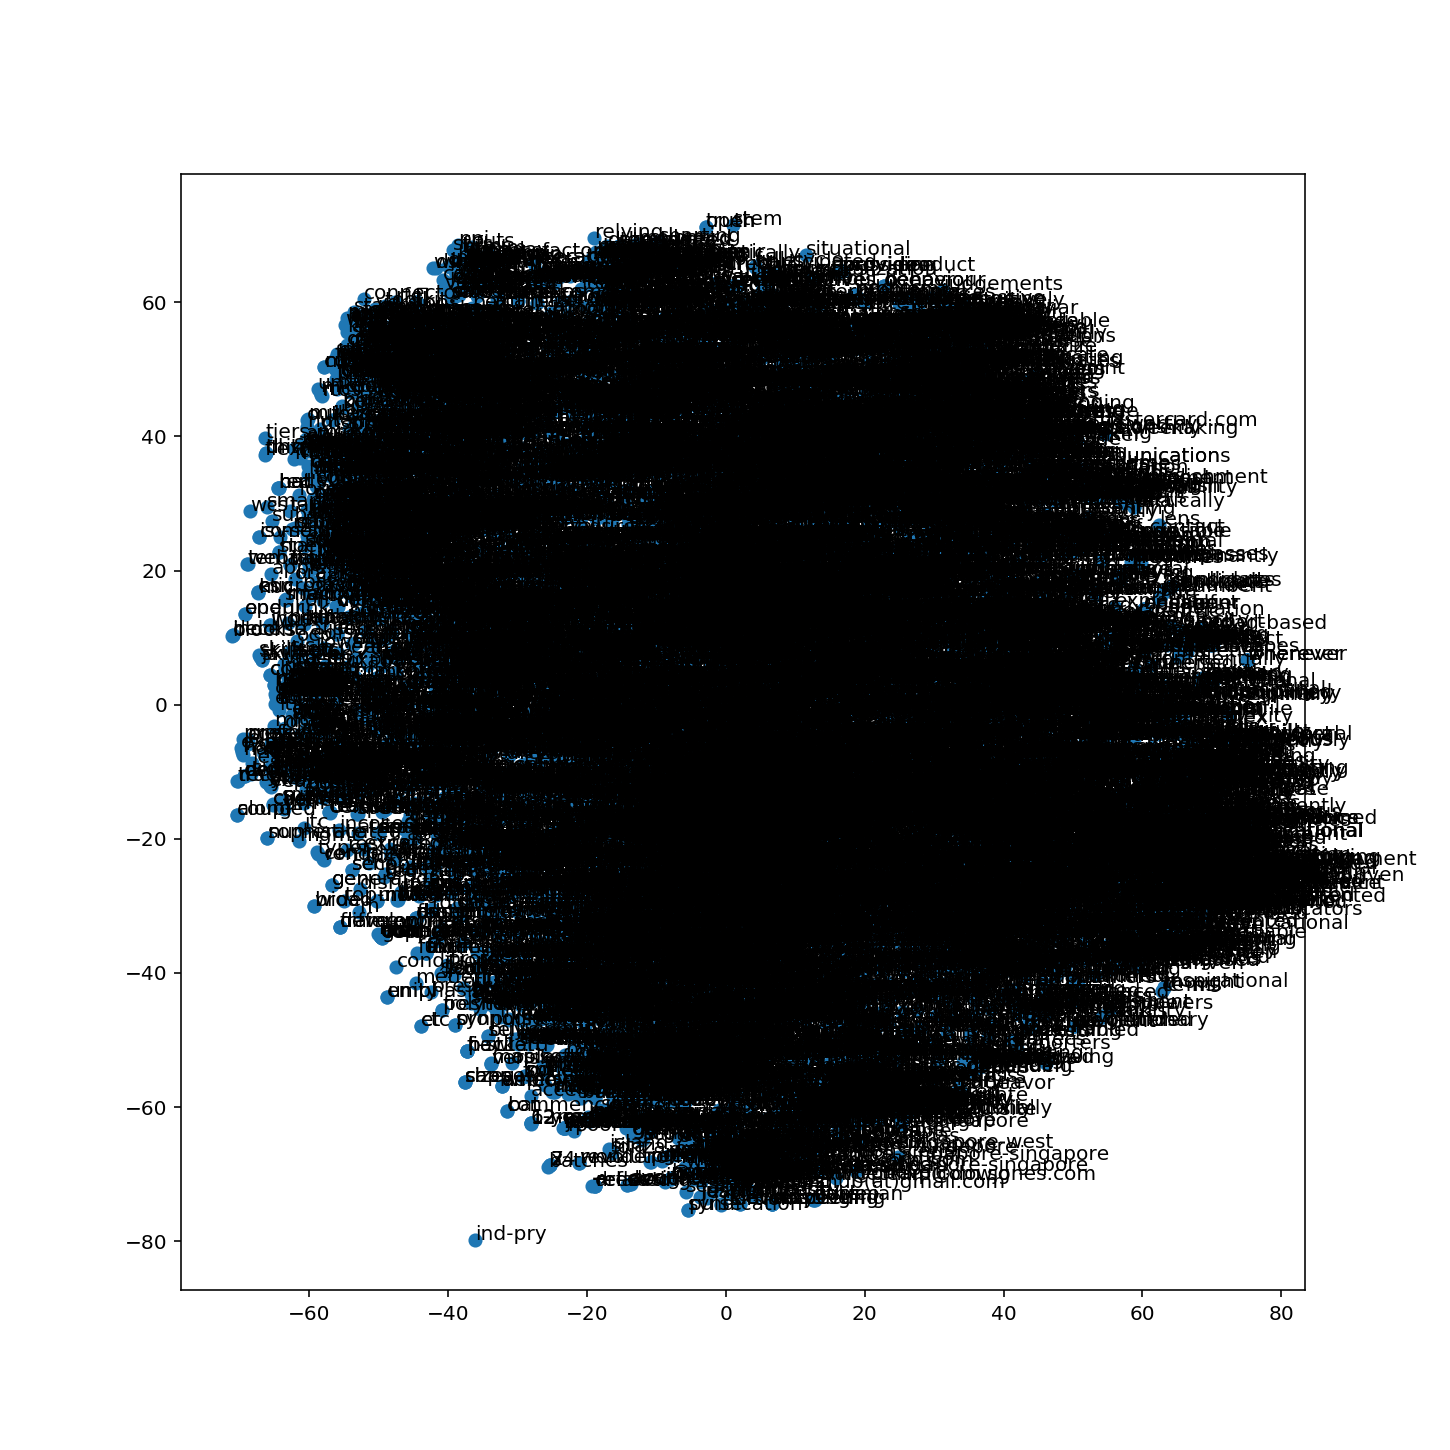

In [34]:
# create a zoomable interactive plot
%matplotlib notebook

# Plot the 2D representation of the word2vec model,
# with the words in its vocabulary as the labels

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)